# RBM on Bars-and-Stripes

This notebook trains a small **Restricted Boltzmann Machine (RBM)** on a classic synthetic binary dataset: **Bars-and-Stripes**.

**What you will do**
1. Generate a Bars-and-Stripes dataset on an \(H\times W\) binary grid.
2. Train an RBM using **Contrastive Divergence** (CD-\(k\)) and optionally **Persistent CD** (PCD).
3. Visualize:
   - training data samples,
   - learned hidden features (columns of \(W\)),
   - samples generated by block Gibbs sampling.
4. Save figures into the `figs/` directory for inclusion in LaTeX.

**Figures saved**
- `figs/rbm_bs_data.png`
- `figs/rbm_bs_filters.png`
- `figs/rbm_bs_samples.png`
- (optional) `figs/rbm_bs_training_curve.png`


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

# Reproducibility
SEED = 0
rng = np.random.default_rng(SEED)

FIG_DIR = "figs"
os.makedirs(FIG_DIR, exist_ok=True)

def savefig(name, dpi=200):
    path = os.path.join(FIG_DIR, name)
    plt.savefig(path, dpi=dpi, bbox_inches="tight")
    print("saved:", path)

def sigmoid(x):
    x = np.clip(x, -50, 50)
    return 1.0 / (1.0 + np.exp(-x))

def binarize(p):
    return (rng.random(p.shape) < p).astype(np.float32)

## 1) Bars-and-Stripes dataset

A Bars-and-Stripes pattern is a binary image that consists of either:
- **vertical bars** (each column is all-0 or all-1), or
- **horizontal stripes** (each row is all-0 or all-1).

We include both families and remove duplicates.


In [2]:
def bars_and_stripes(H=4, W=4):
    patterns = []

    # Vertical bars
    for mask in range(2**W):
        cols = [(mask >> j) & 1 for j in range(W)]
        img = np.zeros((H, W), dtype=np.float32)
        for j, val in enumerate(cols):
            img[:, j] = val
        patterns.append(img)

    # Horizontal stripes
    for mask in range(2**H):
        rows = [(mask >> i) & 1 for i in range(H)]
        img = np.zeros((H, W), dtype=np.float32)
        for i, val in enumerate(rows):
            img[i, :] = val
        patterns.append(img)

    # Deduplicate
    uniq = []
    seen = set()
    for img in patterns:
        key = tuple(img.astype(int).ravel().tolist())
        if key not in seen:
            seen.add(key)
            uniq.append(img)
    return np.stack(uniq, axis=0)

H, W = 4, 4
data_imgs = bars_and_stripes(H, W)
X = data_imgs.reshape(len(data_imgs), H*W).astype(np.float32)
print("Bars-and-Stripes dataset size:", X.shape[0], " | visible dim:", X.shape[1])

Bars-and-Stripes dataset size: 30  | visible dim: 16


saved: figs/rbm_bs_data.png


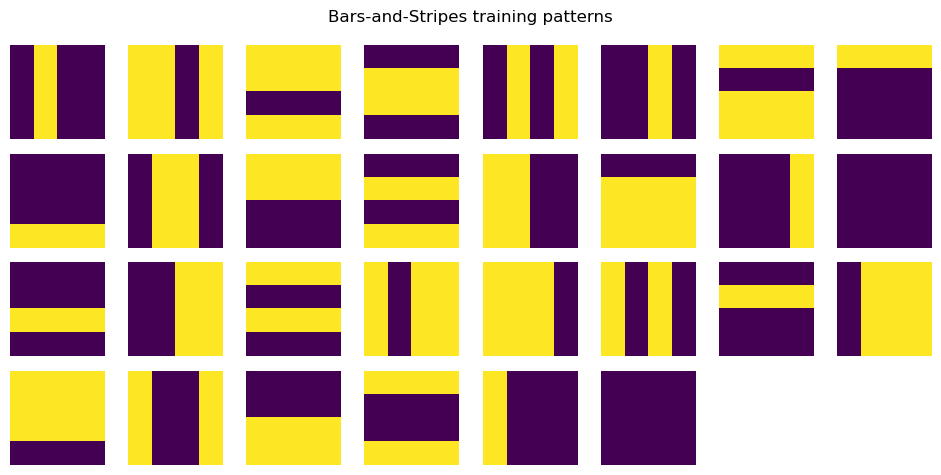

In [3]:
def plot_image_grid(imgs, H, W, nrows=4, ncols=8, title=""):
    n = min(len(imgs), nrows*ncols)
    plt.figure(figsize=(1.2*ncols, 1.2*nrows))
    for k in range(n):
        plt.subplot(nrows, ncols, k+1)
        plt.imshow(imgs[k].reshape(H, W), interpolation="nearest")
        plt.axis("off")
    if title:
        plt.suptitle(title, y=0.98)
    plt.tight_layout()

perm = rng.permutation(len(data_imgs))
plot_image_grid(data_imgs[perm], H, W, nrows=4, ncols=8, title="Bars-and-Stripes training patterns")
savefig("rbm_bs_data.png")
plt.show()

## 2) RBM model (binary-binary)

Energy:
$$
E(v,h) = - v^\top W h - b^\top v - c^\top h.
$$

Conditionals:
$$
p(h=1\mid v)=\sigma(W^\top v + c),\qquad
p(v=1\mid h)=\sigma(Wh + b).
$$


In [4]:
class RBM:
    def __init__(self, n_vis, n_hid, init_scale=0.01, seed=0):
        r = np.random.default_rng(seed)
        self.n_vis = n_vis
        self.n_hid = n_hid
        self.W = r.normal(0.0, init_scale, size=(n_vis, n_hid)).astype(np.float32)
        self.b = np.zeros(n_vis, dtype=np.float32)
        self.c = np.zeros(n_hid, dtype=np.float32)

    def p_h_given_v(self, v):
        return sigmoid(v @ self.W + self.c)

    def p_v_given_h(self, h):
        return sigmoid(h @ self.W.T + self.b)

    def sample_h_given_v(self, v):
        return binarize(self.p_h_given_v(v))

    def sample_v_given_h(self, h):
        return binarize(self.p_v_given_h(h))

    def gibbs_vhv(self, v0, k=1):
        v = v0
        for _ in range(k):
            h = self.sample_h_given_v(v)
            v = self.sample_v_given_h(h)
        h = self.sample_h_given_v(v)
        return v, h

    def free_energy(self, v):
        x = v @ self.W + self.c
        x = np.clip(x, -50, 50)
        return -v @ self.b - np.sum(np.log1p(np.exp(x)), axis=1)

def minibatches(X, batch_size, rng_local):
    N = X.shape[0]
    perm = rng_local.permutation(N)
    for i in range(0, N, batch_size):
        idx = perm[i:i+batch_size]
        yield X[idx]

## 3) Training: CD-\(k\) and optional PCD

We update parameters using the positive phase (data) and a negative phase obtained from a short Gibbs chain.
For PCD, the negative chain state persists across updates.


In [5]:
def train_rbm(
    rbm,
    X,
    epochs=1200,
    batch_size=16,
    lr=0.05,
    cd_k=1,
    use_pcd=False,
    pcd_particles=64,
    verbose_every=200,
    seed=0,
):
    rng_local = np.random.default_rng(seed)
    trace = []

    if use_pcd:
        v_p = (rng_local.random((pcd_particles, rbm.n_vis)) < 0.5).astype(np.float32)

    for ep in range(1, epochs+1):
        for v0 in minibatches(X, batch_size, rng_local):
            v0 = v0.astype(np.float32)

            # Positive phase
            ph0 = rbm.p_h_given_v(v0)

            # Negative phase
            if use_pcd:
                v_neg, _ = rbm.gibbs_vhv(v_p, k=cd_k)
                v_p = v_neg
            else:
                v_neg, _ = rbm.gibbs_vhv(v0, k=cd_k)

            ph_neg = rbm.p_h_given_v(v_neg)

            # Gradients (mean over batch)
            dW = (v0.T @ ph0 - v_neg.T @ ph_neg) / v0.shape[0]
            db = np.mean(v0 - v_neg, axis=0)
            dc = np.mean(ph0 - ph_neg, axis=0)

            rbm.W += lr * dW.astype(np.float32)
            rbm.b += lr * db.astype(np.float32)
            rbm.c += lr * dc.astype(np.float32)

        # Simple monitoring: free-energy gap between data and a reference model sample
        v_ref = (rng_local.random(X.shape) < 0.5).astype(np.float32)
        v_model, _ = rbm.gibbs_vhv(v_ref, k=cd_k)
        gap = float(np.mean(rbm.free_energy(X)) - np.mean(rbm.free_energy(v_model)))
        trace.append(gap)

        if (ep % verbose_every) == 0 or ep == 1:
            print(f"epoch {ep:4d}/{epochs}: free-energy gap (data - model) = {gap:+.4f}")

    return np.array(trace, dtype=np.float32)

# Hyperparameters for a clean demo
n_vis = H*W
n_hid = 12
rbm = RBM(n_vis=n_vis, n_hid=n_hid, init_scale=0.01, seed=SEED)

loss_trace = train_rbm(
    rbm, X,
    epochs=1200,
    batch_size=16,
    lr=0.05,
    cd_k=1,
    use_pcd=False,   # set True to try PCD
    pcd_particles=64,
    verbose_every=200,
    seed=SEED,
)

epoch    1/1200: free-energy gap (data - model) = +0.0172
epoch  200/1200: free-energy gap (data - model) = -0.0108
epoch  400/1200: free-energy gap (data - model) = -0.2621
epoch  600/1200: free-energy gap (data - model) = -0.4589
epoch  800/1200: free-energy gap (data - model) = -1.2537
epoch 1000/1200: free-energy gap (data - model) = -1.7283
epoch 1200/1200: free-energy gap (data - model) = -2.3048


saved: figs/rbm_bs_training_curve.png


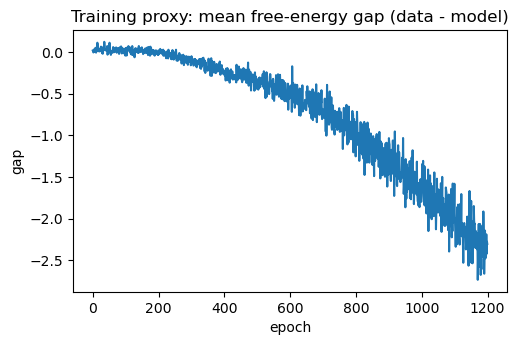

In [6]:
plt.figure(figsize=(5.6, 3.4))
plt.plot(loss_trace)
plt.title("Training proxy: mean free-energy gap (data - model)")
plt.xlabel("epoch")
plt.ylabel("gap")
savefig("rbm_bs_training_curve.png")
plt.show()

## 4) Learned features (columns of \(W\))

We reshape columns of \(W\) into \(H\times W\) images. Each column corresponds to a hidden unit and often becomes a reusable template.


saved: figs/rbm_bs_filters.png


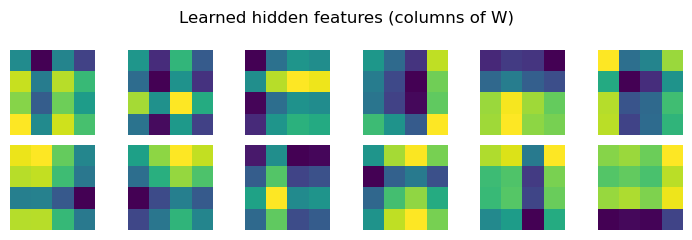

In [7]:
def plot_filters(Wmat, H, W, ncols=6, title="Learned RBM filters"):
    n_vis, n_hid = Wmat.shape
    ncols = min(ncols, n_hid)
    nrows = int(np.ceil(n_hid / ncols))
    plt.figure(figsize=(1.2*ncols, 1.2*nrows))
    for j in range(n_hid):
        plt.subplot(nrows, ncols, j+1)
        plt.imshow(Wmat[:, j].reshape(H, W), interpolation="nearest")
        plt.axis("off")
    plt.suptitle(title, y=0.98)
    plt.tight_layout()

plot_filters(rbm.W, H, W, ncols=6, title="Learned hidden features (columns of W)")
savefig("rbm_bs_filters.png")
plt.show()

## 5) Sampling from the trained RBM

We generate samples by running block Gibbs sampling starting from random visible states.


saved: figs/rbm_bs_samples.png


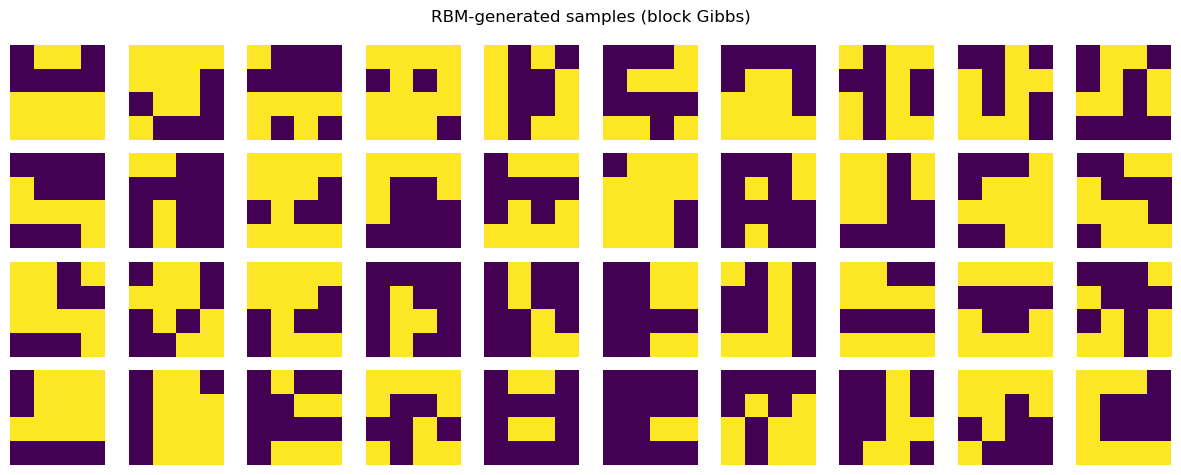

In [8]:
def sample_from_rbm(rbm, n_samples=40, burn_in=200, thin=10, seed=0):
    rng_local = np.random.default_rng(seed)
    v = (rng_local.random((n_samples, rbm.n_vis)) < 0.5).astype(np.float32)

    # burn-in
    v, _ = rbm.gibbs_vhv(v, k=burn_in)

    # thinning and collection
    samples = []
    for _ in range(8):
        v, _ = rbm.gibbs_vhv(v, k=thin)
        samples.append(v.copy())
    return np.concatenate(samples, axis=0)

V_samp = sample_from_rbm(rbm, n_samples=24, burn_in=200, thin=10, seed=SEED)

plot_image_grid(V_samp.reshape(-1, H, W), H, W, nrows=4, ncols=10, title="RBM-generated samples (block Gibbs)")
savefig("rbm_bs_samples.png")
plt.show()

## 6) Suggested extensions
- Increase/decrease `n_hid` (hidden units) to see under/over-parameterization.
- Compare CD-1 vs CD-10 by changing `cd_k`.
- Switch `use_pcd=True` to try persistent chains (PCD).
